In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline

CleanDataset = r'./Dataset/OnlineRetail.csv'
Data_Cleaned = pd.read_csv(CleanDataset, index_col = 'InvoiceDate')
Data_Cleaned.index = pd.to_datetime(Data_Cleaned.index, format = '%Y-%m-%d %H:%M')
Data_Cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
InvoiceDate,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.95,17850.0,UNITED KINGDOM,17.7,December,Wednesday
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.75,17850.0,UNITED KINGDOM,22.5,December,Wednesday
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,4.15,17850.0,UNITED KINGDOM,33.2,December,Wednesday
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.75,17850.0,UNITED KINGDOM,22.5,December,Wednesday
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,4.25,17850.0,UNITED KINGDOM,25.5,December,Wednesday


In [7]:
Data = Data_Cleaned.copy()
Data['Country'] = Data['Country'].map(lambda x: 'UK' if x=='UNITED KINGDOM' else 'non-UK')
CustomerData = Data.groupby(['CustomerID','Country'], sort=False).agg({'Quantity':'mean','UnitPrice':'mean','InvoiceNo':'nunique','Description':'nunique'})
CustomerData.reset_index(inplace=True)
CustomerData.columns = ['CustomerID', 'UK?', 'Average Quantity', 'Average Price', 'Repeats', 'Product Variety']
CustomerData.head(10)

,CustomerID,UK?,Average Quantity,Average Price,Repeats,Product Variety
0,17850.0,UK,5.513158,3.740428,35,24
1,13047.0,UK,6.984536,4.016289,16,105
2,12583.0,non-UK,21.182979,2.182894,17,116
3,13748.0,UK,15.678571,4.053571,5,24
4,15100.0,UK,9.666667,12.750000,6,1
5,15291.0,UK,19.194444,4.902778,19,62
6,14688.0,UK,8.997207,2.089665,27,150
7,17809.0,UK,32.000000,3.030794,14,48
8,15311.0,UK,15.142513,2.644990,118,580
9,16098.0,UK,9.166667,4.045606,7,33


In [9]:
Scaler = StandardScaler()
CustomerData.iloc[:,2:] = Scaler.fit_transform(CustomerData.iloc[:,2:])
syms = CustomerData.iloc[:,0].values.astype(str)
X = CustomerData.iloc[:,1:].values.astype(object)

for n in range(2,8):
    kproto = KPrototypes(n_clusters = n, init = 'Cao')
    clusters = kproto.fit_predict(X, categorical = [0])
    silhouette = silhouette_score(X[:,1:],clusters)
    print('number of clusters:', n)
    print('  cost: ',kproto.cost_)
    print('  average silhouette score: ',silhouette)

number of clusters: 2
  cost:  14380.190053147266
  average silhouette score:  0.5520788140635531
number of clusters: 3
  cost:  11496.15229254785
  average silhouette score:  0.5676629473885375
number of clusters: 4
  cost:  9077.880307323803
  average silhouette score:  0.4031409679309457
number of clusters: 5
  cost:  6847.479936487127
  average silhouette score:  0.4130000199916561
number of clusters: 6
  cost:  6057.460050422227
  average silhouette score:  0.28940478693937444
number of clusters: 7
  cost:  5301.42396554234
  average silhouette score:  0.31601320094147456


In [10]:
kproto = KPrototypes(n_clusters = 3, init = 'Cao')
clusters = kproto.fit_predict(X, categorical = [0])
print('Cluster Centers:\n', kproto.cluster_centroids_)

Cluster Centers:
 [['-0.024614626936218086' '-0.16364306536106285' '2.256325457272765'
  '2.497429797985104' 'UK']
 ['-0.14595561673031704' '1.4741411578894013' '-0.18196347031116064'
  '-0.4037678629862371' 'UK']
 ['0.04195527491035916' '-0.38955183663329135' '-0.1373871556506592'
  '-0.09672962595107741' 'UK']]


In [11]:
Clustered = pd.DataFrame(data=Scaler.inverse_transform(CustomerData.iloc[:,2:]),columns=['Average Quantity', 'Average Price', 'Repeats', 'Product Variety'])
Clustered['UK?'] = X[:,0]
Clustered['CustomerID'] = syms
Clustered['Cluster'] = clusters
print(Clustered.groupby(['Cluster','UK?']).count()['Repeats'],'\n\n\n')
print(Clustered.groupby(['Cluster','UK?']).mean())

Cluster  UK?   
0        UK         240
         non-UK      26
1        UK         802
         non-UK      75
2        UK        2888
         non-UK     319
Name: Repeats, dtype: int64 



                Average Quantity  Average Price    Repeats  Product Variety
Cluster UK?                                                                
0       UK             15.024194       2.838119  24.741667       270.604167
        non-UK         19.279329       2.910548  31.615385       325.884615
1       UK             10.677712       5.159754   3.325436        25.721945
        non-UK          7.970224       5.253565   3.360000        38.413333
2       UK             18.001254       2.526568   3.756233        53.107341
        non-UK         19.796992       2.509120   3.514107        53.843260


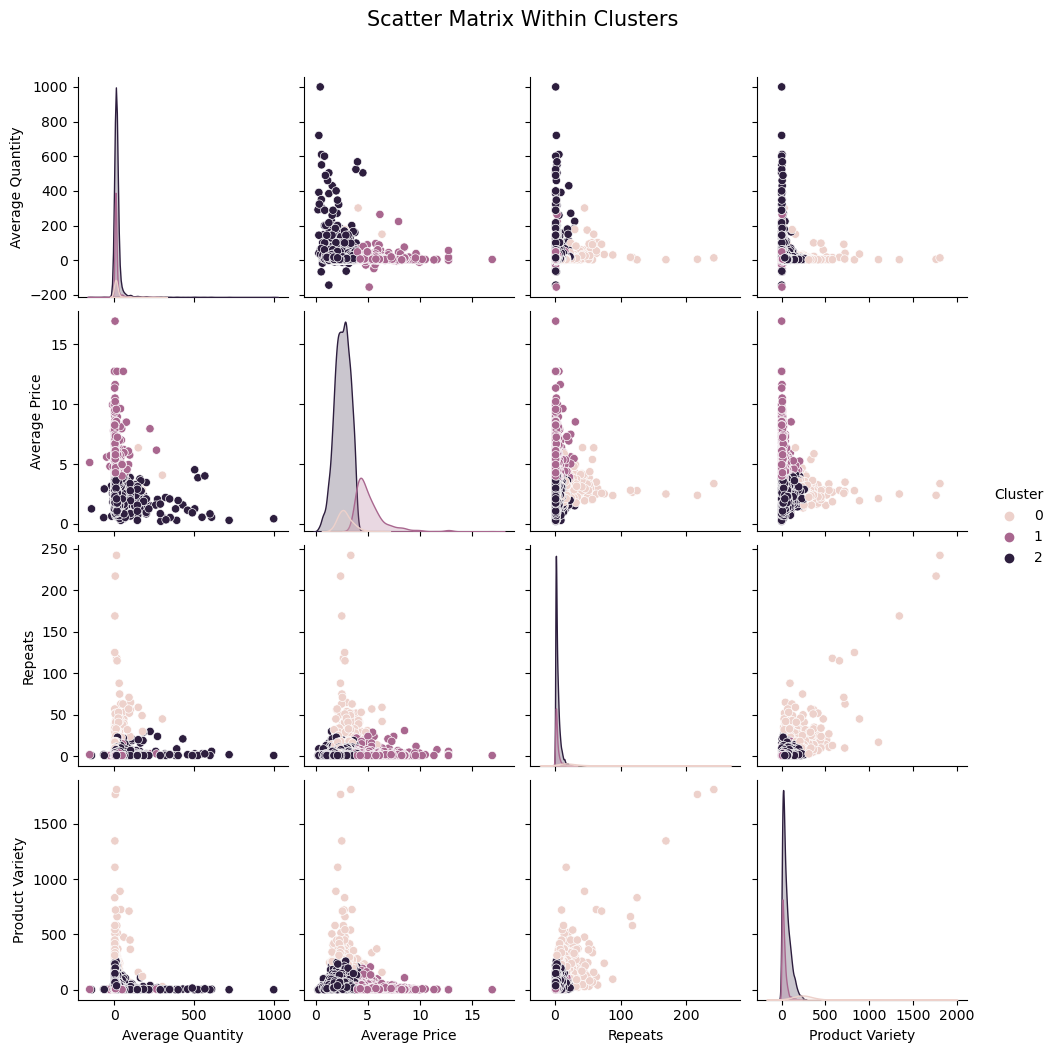

In [12]:
sns.pairplot(Clustered.drop(columns=['UK?','CustomerID']), hue='Cluster')
plt.suptitle('Scatter Matrix Within Clusters', fontsize = 15, y = 1.05)
plt.show()